# INTRODUÇÃO

O objetivo deste relatório é realizar a análise de mensagens enviadas em um grupo do Telegram. Para isso foi criado um bot com o objetivo de armazenar as mensagens. Os dados coletados foram acessados por meio da API de bots do Telegram e posteriormente analisados através de consultas SQL por meio do sistema AWS Athena.

## CHATBOTS

Bots podem ser definidos como aplicações que executam tarefas automatizadas dentro de um sistema. Um chatbot permite que o usuário delegue tarefas através de comando de texto ou voz (conversas, ou, em inglês, *chat*). Atualmente, os chatbots utilizam o processamento de linguagem natural (PLN), sendo capazes de entender e responder perguntas e atuar em tarefas de grande complexidade. ( [AWS Amazon](https://aws.amazon.com/pt/what-is/chatbot/), [Telegram](https://core.telegram.org/bots/api))

# ARQUITETURA



## API DE BOTS DO TELEGRAM

No aplicativo Telegram, os bots funcionam como interfaces leves e acessíveis para interações rápidas e seguras, como envio de notificações, recebimento de comandos e até mesmo processamento de requisições. Ela possui a vantagem de ser gratuita e de uso irrestrito, permitindo a criação de bots por iniciantes na área. [Apidog](https://apidog.com/pt/blog/beginners-guide-to-telegram-bot-api-pt/)

Na figura abaixo é possível observar todas as etapas que serão executadas neste projeto.

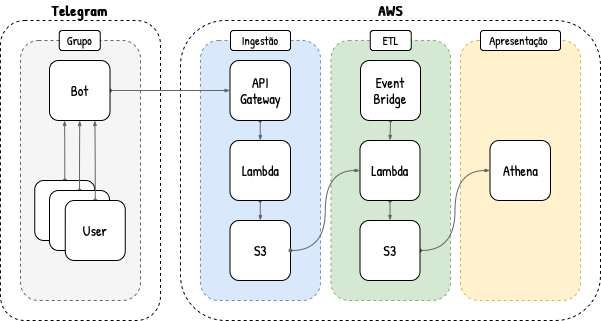

## 1. INGESTÃO

Neste processo, os dados transacionais são ingeridos no ambiente analítico. Assim, os dados obtidos pela API do Telegram são enviados para uma API Web da AWS através de um webhook. Nesta etapa eles ainda se encontram no formato original, sem nenhuma modificação de sua estrutura.
No sistema AWS, foi criada uma função Lambda para redirecionar os dados, em formato JSON para armazenamento em buckets do AWS S3.

### Importação de bibliotecas

In [ ]:
from getpass import getpass
import json
import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Acesso à API do Telegram

In [ ]:
token = getpass()

··········


In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 703896414,
      "message": {
        "message_id": 6,
        "from": {
          "id": 8343375342,
          "is_bot": false,
          "first_name": "Marina",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002423405103,
          "title": "M42 Ebac Group",
          "type": "supergroup"
        },
        "date": 1754066335,
        "text": "Ol\u00e1 ol\u00e1"
      }
    },
    {
      "update_id": 703896415,
      "message": {
        "message_id": 7,
        "from": {
          "id": 8343375342,
          "is_bot": false,
          "first_name": "Marina",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002423405103,
          "title": "M42 Ebac Group",
          "type": "supergroup"
        },
        "date": 1754066339,
        "text": "Boa tarde!"
      }
    },
    {
      "update_id": 703896416,
      "message": {
        "message_id": 8,
        "from":

### Criação da função Lambda

A função Lambda foi criada com o seguinte código:



In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

### Criação de uma API do AWS API Getway e configuração do Webhook

In [ ]:
# setWebhook

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

## 2. ETL

Nesta etapa foi feita a manipulação (extraction, transformation and loading) dos dados ingeridos na etapa anterior. Foi criada outra função Lambda que realiza o processo contínuo de data wrangling, onde será feita a limpeza, alteração de formato e particionamento dos dados. Em seguida, os dados enriquecidos são enviados para outro bucket do AWS S3 onde podem ser consultados.
A criação de uma função do AWS Event Bridge permite essa função lambda seja executada rotineiramente.

### Função Lambda

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  #Diariamente é executado para compactar as diversas mensagensm, no formato
  #JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  #arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

      # código da função de data wrangling

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

## 3. APRESENTAÇÃO

Os dados obtidos foram acessados através do sistema AWS Athena, que permite a consulta dos dados armazenados nos buckest do AWS S3 através de consultas SQL

# ANALYTICS

A seguir serão apresentados os resultados dos dados obtidos do grupo do Telegram. Infelizmente, por ser um grupo recente e que conta apenas com um único usuário, há poucas entradas (mensagens) e não poderão ser obtidas muitas informações dos dados. Pórem esse relatório poderá ser atualizado à medida que o grupo evolua.

* **QUERY 01:** Primeiras 10 linhas da tabela

> SELECT * FROM `telegram` LIMIT 10;

In [ ]:
!wget -q 'https://raw.githubusercontent.com/marinafso/projeto-ebac-telegram-mfso/refs/heads/main/q_01.csv' -O q_01.csv

df_q01 = pd.read_csv('q_01.csv')
df_q01

,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,10,8343375342,False,Marina,-1002423405103,supergroup,Oi pessoal,1754080336,2025-08-01
1,13,8343375342,False,Marina,-1002423405103,supergroup,Parece que está dando certo 💃💃💃,1754080425,2025-08-01
2,14,8343375342,False,Marina,-1002423405103,supergroup,Uhuuu,1754080430,2025-08-01
3,11,8343375342,False,Marina,-1002423405103,supergroup,Hora de testar a integração entre API e bots ...,1754080364,2025-08-01
4,12,8343375342,False,Marina,-1002423405103,supergroup,Vamo que vamo,1754080370,2025-08-01
5,18,8343375342,False,Marina,-1002423405103,supergroup,Parece que ninguém usa esse grupo,1754431212,2025-08-05
6,19,8343375342,False,Marina,-1002423405103,supergroup,Group is dead RIP 🎃☠,1754431229,2025-08-05
7,20,8343375342,False,Marina,-1002423405103,supergroup,Desabafando só pra criar mensagens para o projeto,1754431259,2025-08-05
8,21,8343375342,False,Marina,-1002423405103,supergroup,Digitando...,1754431270,2025-08-05
9,22,8343375342,False,Marina,-1002423405103,supergroup,Amanhã eu termino esse trabalho,1754431290,2025-08-05


* **QUERY 02:** quantidade de mensagens por dia

In [ ]:
SELECT
    context_date,
    count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC

In [ ]:
!wget -q 'https://raw.githubusercontent.com/marinafso/projeto-ebac-telegram-mfso/refs/heads/main/q_02.csv' -O q_02.csv

df_q02 = pd.read_csv('q_02.csv')
df_q02

,context_date,message_amount
0,2025-08-05,6
1,2025-08-01,5


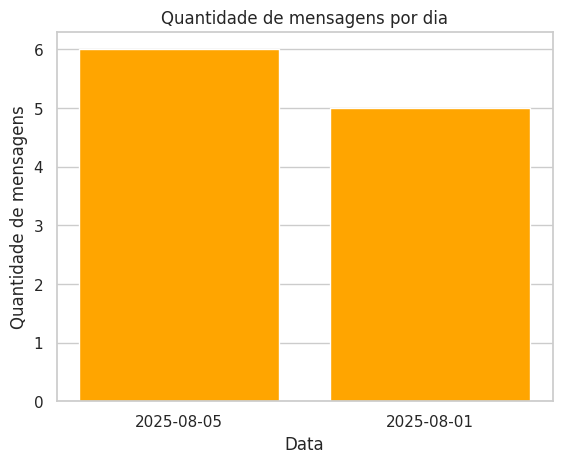

In [ ]:
plt.bar(df_q02['context_date'], df_q02['message_amount'], color = 'orange')
plt.xlabel('Data')
plt.ylabel('Quantidade de mensagens')
plt.title('Quantidade de mensagens por dia')
plt.xticks()
plt.grid(axis='x')
plt.show()

* **QUERY 03:** quantidade de mensagens por usuário por dia.

In [ ]:
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

In [ ]:
!wget -q 'https://raw.githubusercontent.com/marinafso/projeto-ebac-telegram-mfso/refs/heads/main/q_03.csv' -O q_03.csv

df_q03 = pd.read_csv('q_03.csv')
df_q03

,user_id,user_first_name,context_date,message_amount
0,8343375342,Marina,2025-08-05,6
1,8343375342,Marina,2025-08-01,5


Text(0.5, 1.0, 'Quantidade de mensagens por usuário por dia')

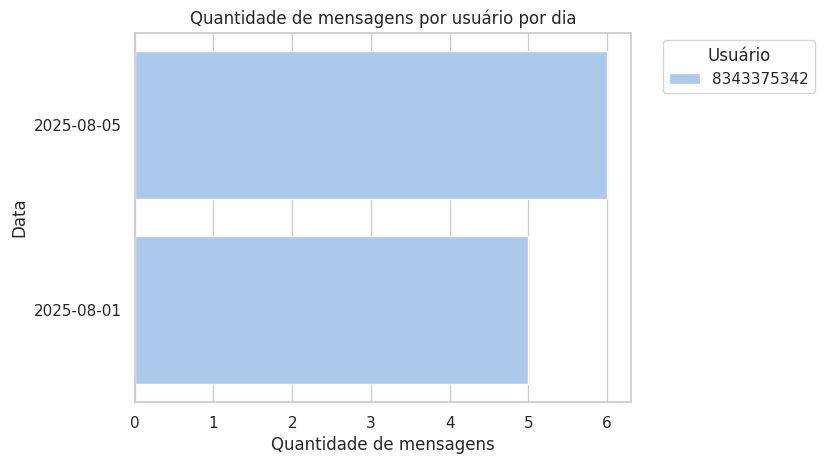

In [ ]:
sns.set_theme(style="whitegrid")
sns.barplot(x='message_amount', y='context_date', hue='user_id', data=df_q03, palette='pastel', orient='h')
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Data')
plt.legend(title='Usuário', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Quantidade de mensagens por usuário por dia')

* **QUERY 04:** quantidade de mensagens por hora por dia da semana por número da semana

In [ ]:
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

In [ ]:
!wget -q 'https://raw.githubusercontent.com/marinafso/projeto-ebac-telegram-mfso/refs/heads/main/q_04.csv' -O q_04.csv

df_q04 = pd.read_csv('q_04.csv')
df_q04

,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,20,5,31,5
1,23,2,32,1
2,22,2,32,5


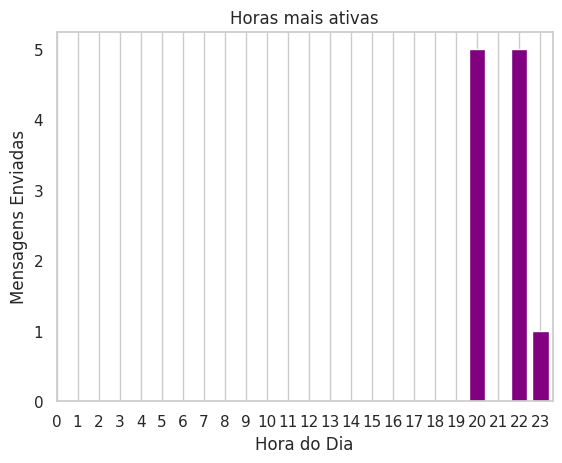

In [ ]:
plt.bar(df_q04['parsed_date_hour'], df_q04['message_amount'], color='purple')
plt.xlabel('Hora do Dia')
plt.ylabel('Mensagens Enviadas')
plt.title('Horas mais ativas')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

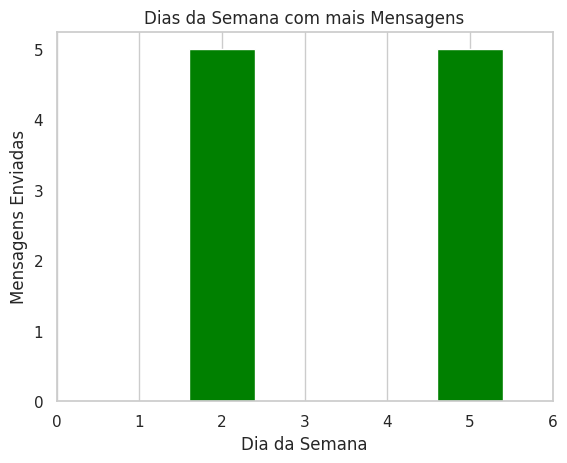

In [ ]:
plt.bar(df_q04['parsed_date_weekday'], df_q04['message_amount'], color='green')
plt.xlabel('Dia da Semana')
plt.ylabel('Mensagens Enviadas')
plt.title('Dias da Semana com mais Mensagens')
plt.xticks(range(0, 7))
plt.grid(axis='y')
plt.show()

* **QUERY 05:** Média do tamanho das mensagens por usuário por dia

In [ ]:
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

In [ ]:
!wget -q 'https://raw.githubusercontent.com/marinafso/projeto-ebac-telegram-mfso/refs/heads/main/q_05.csv' -O q_05.csv

df_q05 = pd.read_csv('q_05.csv')
df_q05

,user_id,user_first_name,context_date,average_message_length
0,8343375342,Marina,2025-08-05,38
1,8343375342,Marina,2025-08-01,23


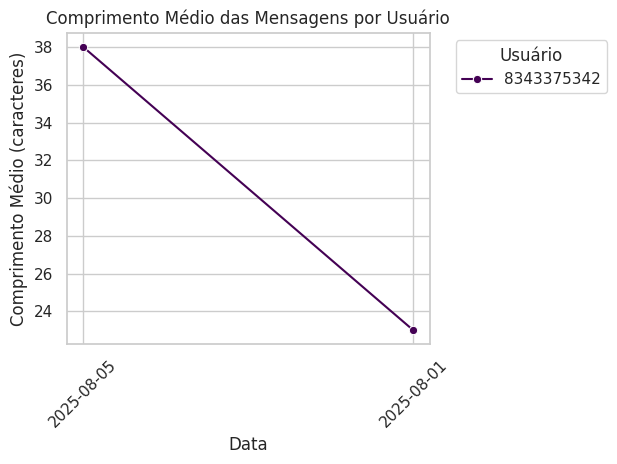

In [ ]:
sns.lineplot(data=df_q05, x='context_date', y='average_message_length', hue='user_id',  marker='o', palette='viridis')
plt.title("Comprimento Médio das Mensagens por Usuário")
plt.xlabel("Data")
plt.ylabel("Comprimento Médio (caracteres)")
plt.xticks(rotation=45)
plt.legend(title='Usuário', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()